In [9]:
# Analysis of global COVID-19 data



## We want to determine if the Match of foreign educated medical students (US-IMGs and non-US-IMGs) are impacted by major geopolitical events

# Import relevant programs
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import image as image
from matplotlib import cbook as cbook
# import matplotlib.gridspec as gridspec

In [10]:
#Load COVID Data

covid_data = pd.read_csv('../Data/JHU/time_series_covid19_confirmed_global.csv')
covid_data = covid_data.drop(columns=['Province/State', 'Lat', 'Long'])
covid_data.rename(columns = {'Country/Region': 'Country'}, inplace = True)
covid_data = covid_data.groupby('Country').agg('sum')

In [11]:
# Create a time series by transforming the covid.data 

covid_data = covid_data.T
datetime_index = pd.to_datetime(covid_data.index)
covid_data = covid_data.set_index(datetime_index)
covid_data.rename(columns = {'Korea, South': 'South Korea'}, inplace = True)

# covid_data.head()

In [12]:
#Phase 1 countries

phase1 = covid_data.loc[:, ['Austria', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'US']]

# phase1.head()





In [18]:
a = 'Switzerland'
cutoff100 = phase1.loc[phase1[a] > 100]
cutoff100 = cutoff100[a]

cutoff100.head(20)

2020-03-05     114
2020-03-06     214
2020-03-07     268
2020-03-08     337
2020-03-09     374
2020-03-10     491
2020-03-11     652
2020-03-12     652
2020-03-13    1139
2020-03-14    1359
2020-03-15    2200
2020-03-16    2200
2020-03-17    2700
2020-03-18    3028
2020-03-19    4075
2020-03-20    5294
2020-03-21    6575
2020-03-22    7474
2020-03-23    8795
2020-03-24    9877
Name: Switzerland, dtype: int64

In [15]:
a = 'Switzerland'

all100cuts = pd.concat([all100cuts, cutoff100.iloc])

all100cuts.head()




TypeError: cannot concatenate object of type '<class 'pandas.core.indexing._iLocIndexer'>'; only Series and DataFrame objs are valid

In [16]:
stablized_countries = covid_data.loc[:, ['Iran', 'Japan', 'South Korea']]


# stablized_countries.head()

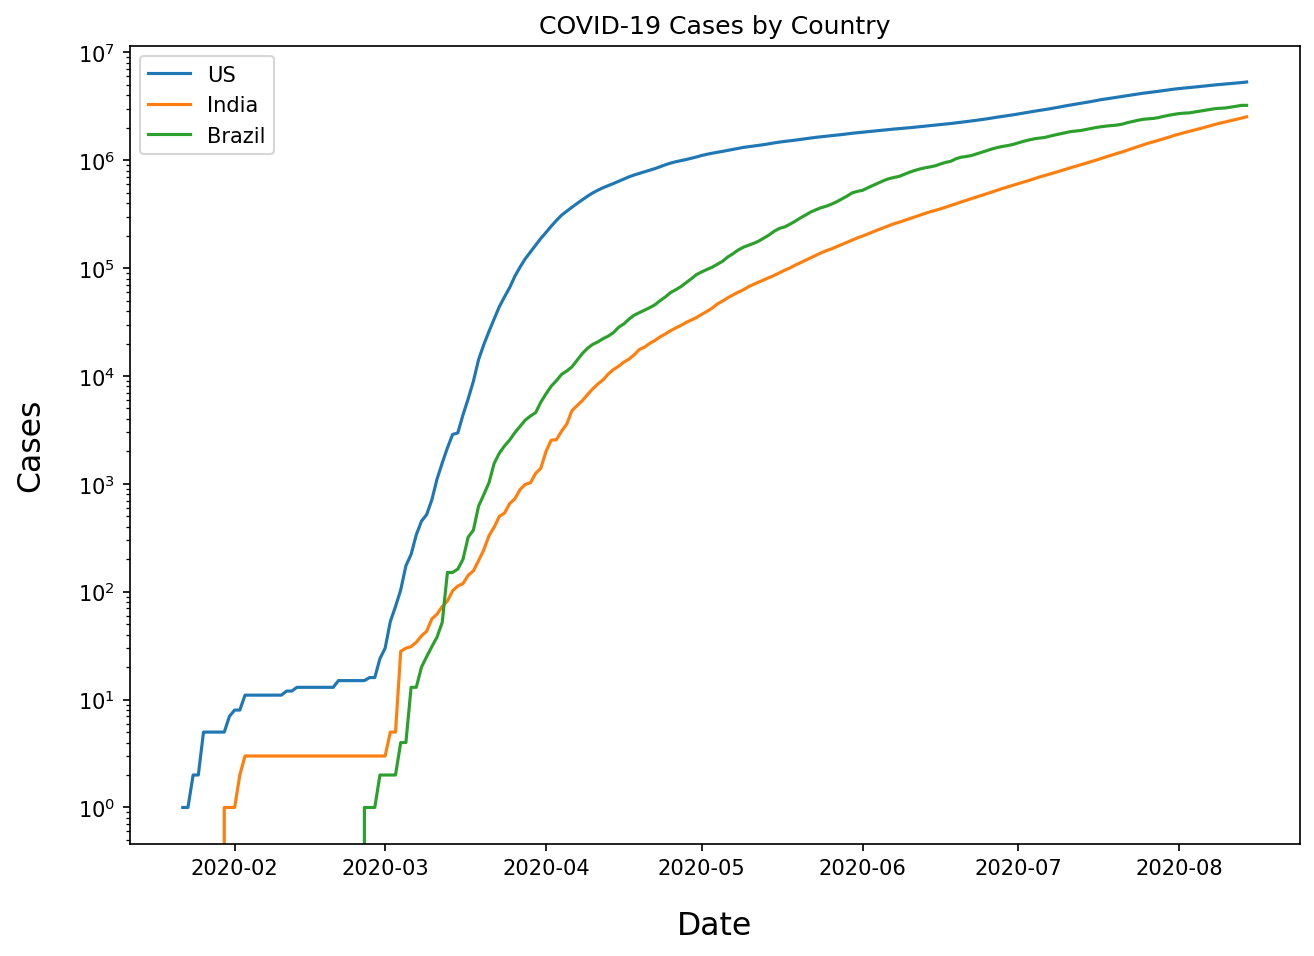

In [17]:
# Plot the data

#Initialize figure
fig1, ax1 = plt.subplots(figsize=(10, 7), dpi = 151)
selected_countries = ['US', 'India', 'Brazil']
plotting_columns = covid_data[selected_countries]

axes_fontsize = 15

# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(datetime_index, plotting_columns)



#Formatting

plt.title('COVID-19 Cases by Country')
ax1.legend(selected_countries) #set to show selected_countries
ax1.set_xlabel("Date", fontsize=axes_fontsize)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases', fontsize=axes_fontsize)
ax1.set_yscale('log')

plt.show()